# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации `Shift+Tab`. Нажатие `Tab` после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __`pandas.read_csv`__ в переменную __`df`__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [3]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('data/bikes_rent.csv')
print df.head(5)

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* `season`: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`: 0 - 2011, 1 - 2012
* `mnth`: от 1 до 12
* `holiday`: 0 - нет праздника, 1 - есть праздник
* `weekday`: от 0 до 6
* `workingday`: 0 - нерабочий день, 1 - рабочий день
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`: температура в Цельсиях
* `atemp`: температура по ощущениям в Цельсиях
* `hum`: влажность
* `windspeed(mph)`: скорость ветра в милях в час
* `windspeed(ms)`: скорость ветра в метрах в секунду
* `cnt`: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальными признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных.

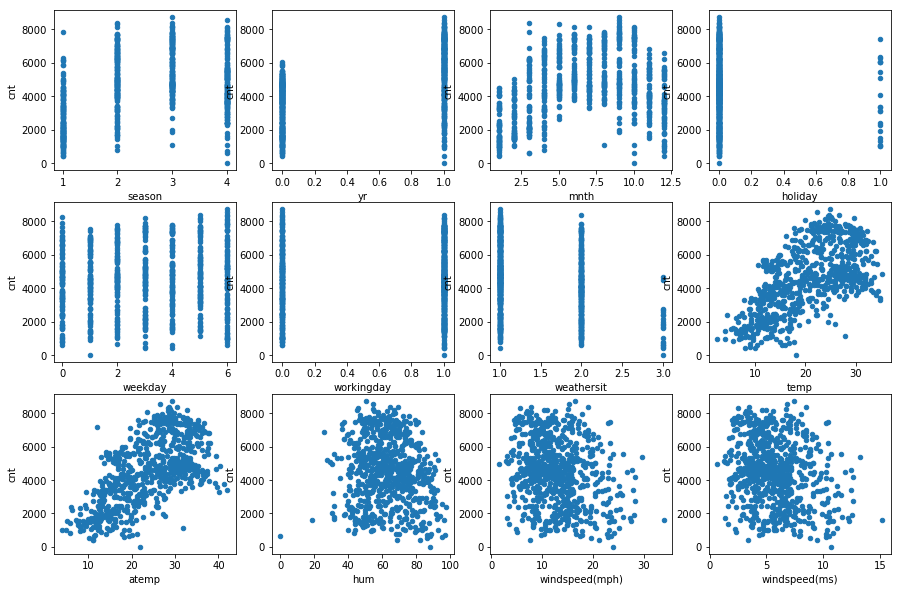

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

------

### Блок 1. Ответьте на вопросы (каждый 0.5 балла):

1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: характер зависимости можно описать параболой(многочленом второй степени) с вершиной около x = 6.
   Можно также описать и многочленом более высокой степени(3-4 не более), так как экстремумов судя по графику несколько, но есть риск переобучения.
2. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp(температура) и  atemp(ощущаемая тепрпература) судя по график, однако из двух графиков ясно, что эти 2 признака сильно скоррелированны.
   
------

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: `corr` и `corrwith`. Метод `df.corr` вычисляет матрицу корреляций всех признаков из датафрейма. Методу `df.corrwith` нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из `df` и этого датафрейма.

In [5]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
#print df.iloc[:,:-1]
#print df.iloc[:,-1]
#print df['cnt']
print df.iloc[:,:-1].corrwith(df.iloc[:,-1])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [6]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
corr_tmp = df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()
print corr_tmp

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: `temp` и `atemp` (коррелируют по своей природе) и два `windspeed` (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод `mean`), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [7]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean(axis=0)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода `scale`.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [10]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [11]:
from sklearn.linear_model import LinearRegression

In [14]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

# create linar regression object
my_linear_model = LinearRegression(fit_intercept=True,normalize=False)
#print type(my_linear_model)

#train linear regression
model_fit = my_linear_model.fit(X=X, y=y)
#print type(model_fit)
print model_fit

# coefficients:
#print 'Coefficients:\n', model_fit.coef_

# pairs(feature name, coef):
#print list(df.columns[:-1])
coef_pairs = zip( (list(df.columns[:-1])),(model_fit.coef_))
print
print  coef_pairs
print 
for i in range(len( coef_pairs)):
    print coef_pairs[i]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

[('season', 570.87077517081241), ('yr', 1021.9689246859298), ('mnth', -141.30534047164508), ('holiday', -86.757528967927726), ('weekday', 137.22464485932142), ('workingday', 56.390851352823688), ('weathersit', -330.23219391326302), ('temp', 367.47441047339532), ('atemp', 585.55310452138167), ('hum', -145.60839851748983), ('windspeed(mph)', 12457394871096.072), ('windspeed(ms)', -12457394871294.529)]

('season', 570.87077517081241)
('yr', 1021.9689246859298)
('mnth', -141.30534047164508)
('holiday', -86.757528967927726)
('weekday', 137.22464485932142)
('workingday', 56.390851352823688)
('weathersit', -330.23219391326302)
('temp', 367.47441047339532)
('atemp', 585.55310452138167)
('hum', -145.60839851748983)
('windspeed(mph)', 12457394871096.072)
('windspeed(ms)', -12457394871294.529)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в `X` есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такую ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой `temp-atemp` чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Решение проблемы мультиколлинеарности состоит в __регуляризации__ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется __Lasso__, а во втором — __Ridge__. Подробнее об этом также было рассказано в лекции.

Обучите регрессоры `Ridge` и `Lasso` с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [15]:
from sklearn.linear_model import Lasso, Ridge

In [16]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией
lasso_model = Lasso(alpha=40,fit_intercept=True,normalize=False)
model_lasso_fit = lasso_model.fit(X=X, y=y)

print 'Lasso model coef pairs:'
coef_pairs = zip( (list(df.columns[:-1])),(model_lasso_fit.coef_))
for i in range(len( coef_pairs)):
    print coef_pairs[i]

Lasso model coef pairs:
('season', 420.00521032631571)
('yr', 986.07263912808435)
('mnth', -0.0)
('holiday', -61.380853667530161)
('weekday', 101.38970077514719)
('workingday', 26.026613663391753)
('weathersit', -320.56918853368882)
('temp', 334.05322474059307)
('atemp', 605.33891435443775)
('hum', -104.86216548943692)
('windspeed(mph)', -156.23500553266828)
('windspeed(ms)', -2.279272852414549e-08)


In [17]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией
ridge_model = Ridge(alpha=10,fit_intercept=True,normalize=False)
model_ridge_fit = ridge_model.fit(X=X, y=y)

print 'Ridge model coef pairs:'
coef_pairs = zip( (list(df.columns[:-1])),(model_ridge_fit.coef_))
for i in range(len( coef_pairs)):
    print coef_pairs[i]

Ridge model coef pairs:
('season', 539.22540883212787)
('yr', 1006.5644070702882)
('mnth', -110.2251629198382)
('holiday', -86.729732754703122)
('weekday', 135.46941060550915)
('workingday', 55.554319881844393)
('weathersit', -328.67757712249471)
('temp', 436.39490742641937)
('atemp', 514.66000594180844)
('hum', -146.42966386912514)
('windspeed(mph)', -100.227958466099)
('windspeed(ms)', -100.22795847304621)


------

### Блок 2.  Поясните, 

каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

* : 

------

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [93]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.
print alphas

[  1  51 101 151 201 251 301 351 401 451]


### LASSO

In [94]:
for ind, alpha_val in enumerate(alphas):
    lasso_model = Lasso(alpha=alpha_val)
    lasso_fit = lasso_model.fit(X=X, y=y)
    coefs_lasso[ind,:] = lasso_fit.coef_

In [95]:
import pandas as pd 
coefs_lasso_1 = pd.DataFrame(coefs_lasso)
coefs_lasso_1.columns  = df.columns[:-1]
print pd.DataFrame(coefs_lasso_1)

       season           yr        mnth    holiday     weekday  workingday  \
0  560.241616  1019.463494 -128.730627 -86.152781  137.347894   55.212371   
1  410.969632   977.019409   -0.000000 -53.448969   91.943437   17.537212   
2  370.077089   935.945490    0.000000 -12.161936   48.888634    0.000000   
3  332.835717   891.870058    0.000000  -0.000000    0.000000    0.000000   
4  298.134448   845.652857    0.000000  -0.000000    0.000000    0.000000   
5  258.927201   799.237273    0.000000  -0.000000    0.000000    0.000000   
6  217.427513   752.720808    0.000000  -0.000000    0.000000    0.000000   
7  175.929845   706.203788    0.000000  -0.000000    0.000000    0.000000   
8  134.628497   659.632535    0.000000  -0.000000    0.000000    0.000000   
9   93.351742   613.054639    0.000000  -0.000000    0.000000    0.000000   

   weathersit        temp       atemp         hum  windspeed(mph)  \
0 -332.369857  376.363236  576.530794 -144.129155     -197.139689   
1 -318.125568 

## Ridge

In [74]:
for ind, alpha_val in enumerate(alphas):
    ridge_model = Ridge(alpha=alpha_val)
    ridge_fit = ridge_model.fit(X=X, y=y)
    coefs_ridge[ind,:] = ridge_fit.coef_

In [75]:
coefs_ridge_1 = pd.DataFrame(coefs_ridge)
coefs_ridge_1.columns = df.columns[:-1]
print coefs_ridge_1

       season           yr        mnth    holiday     weekday  workingday  \
0  563.064572  1018.948379 -131.873320 -86.746098  138.005111   55.903110   
1  461.178632   954.307742  -41.565450 -84.913470  126.603667   54.251691   
2  403.976530   898.083622    5.674243 -81.911062  117.941411   52.728484   
3  366.604239   848.463465   34.027283 -78.771965  110.680120   51.257192   
4  339.745290   804.251048   52.489873 -75.717408  104.403464   49.841895   
5  319.158641   764.561434   65.152007 -72.819708   98.878804   48.484525   
6  302.636060   728.708540   74.138281 -70.098983   93.955811   47.185338   
7  288.913276   696.145816   80.660457 -67.554852   89.528675   45.943467   
8  277.213216   666.429747   85.459254 -65.178706   85.518667   44.757303   
9  267.031090   639.195368   89.012323 -62.958906   81.864909   43.624770   

   weathersit        temp       atemp         hum  windspeed(mph)  \
0 -332.349788  386.457889  566.347047 -145.071327      -99.259441   
1 -313.275151 

Визуализируем динамику весов при увеличении параметра регуляризации:

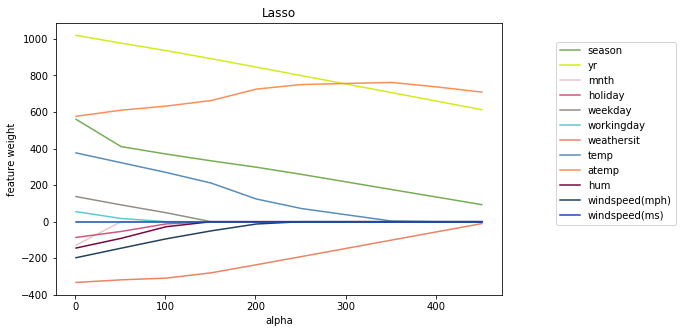

In [80]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

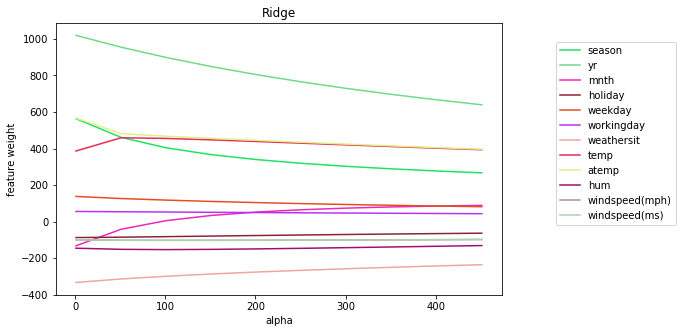

In [81]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

------

### Блок 3. Ответьте на вопросы (каждый 0.25 балла):

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же `alpha`?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: некоторое веса могут обнулиться начиная с некоторого большого по модуля лямбда
    Так происходит, потому что 
1. Можно ли утверждать, что Lasso исключает один из признаков `windspeed` при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: да, это действительно так, можно убедиться имперически
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: lasso, так как ridge не уменьшает число признаков а толко делает в среднем меньшие по модулю веса
    
------

Далее будем работать с Lasso.

Итак, мы видим, что при изменении `alpha` модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее `alpha`. 

Для этого, во-первых, нам __нужна метрика качества__. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, __на каких данных эту метрику считать__. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные «новые» данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения `alpha`, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на `K` частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из `alpha` и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера `len(alpha) x k`, `k = 3` (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по `alphas`; для сопоставления с матрицей MSE лучше использовать переменную регрессора `alphas`.

In [157]:
from sklearn.linear_model import LassoCV, lasso_path

In [274]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1,100,5.0)
print alphas
my_lasso_cv = LassoCV(cv=3,alphas=alphas).fit(X=X,y=y)
print type(my_lasso_cv.mse_path_)
#print my_lasso_cv.mse_path_

lasso_best_alpha = my_lasso_cv.alpha_
print
print "Best alpha on  10 - fold CV:"
print  lasso_best_alpha

[  1.   6.  11.  16.  21.  26.  31.  36.  41.  46.  51.  56.  61.  66.  71.
  76.  81.  86.  91.  96.]
<type 'numpy.ndarray'>

Best alpha on  10 - fold CV:
6.0


In [282]:
# learn model on more time with the best alpha:
lasso_best_model = Lasso(alpha= lasso_best_alpha,).fit(X=X,y=y)
#print lasso_best_model.coef_
lasso_pairs = zip(df.columns[:-1], lasso_best_model.coef_)
for i in range(len(lasso_pairs)):
    print lasso_pairs[i]

('season', 532.0189828413537)
('yr', 1015.0602226430597)
('mnth', -100.03952614356626)
('holiday', -83.293959875299166)
('weekday', 132.50446549095795)
('workingday', 51.557085614073891)
('weathersit', -330.55985673998129)
('temp', 370.67985503003513)
('atemp', 581.39693106549669)
('hum', -140.00740550068869)
('windspeed(mph)', -191.77140847135064)
('windspeed(ms)', -2.6854518176296607e-08)


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [276]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
mse_cv_table = my_lasso_cv.mse_path_
#print type(mse_cv_table)
min_mse_idx = np.argmin(mse_cv_table, axis=0)
print min_mse_idx # idx of row with max mse 
print 
print "Optimal alphas for each train/test split:"
print alphas[min_mse_idx]
#print 
#print mse_cv_table[:,1]

[11 18 19]

Optimal alphas for each train/test split:
[ 56.  91.  96.]


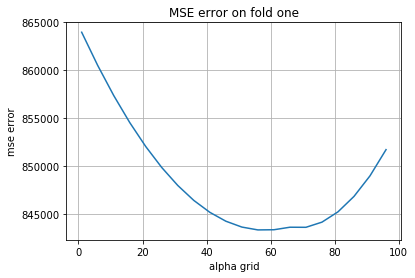

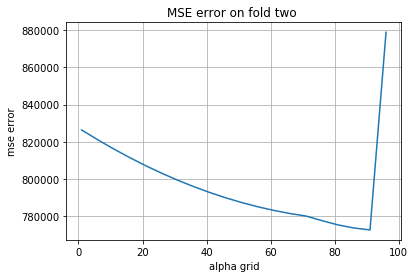

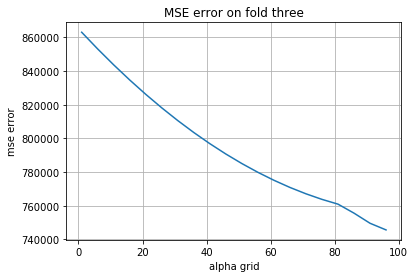

In [281]:
# plots:
import matplotlib.pyplot as plt

# fold one :
plt.plot(alphas, mse_cv_table[:,0])
plt.xlabel("alpha grid")
plt.ylabel("mse error")
plt.title("MSE error on fold one")
plt.grid(True)
plt.show()

# fold two :
plt.plot(alphas, mse_cv_table[:,1])
plt.xlabel("alpha grid")
plt.ylabel("mse error")
plt.title("MSE error on fold two ")
plt.grid(True)
plt.show()


# fold three :
plt.plot(alphas, mse_cv_table[:,2])
plt.xlabel("alpha grid")
plt.ylabel("mse error")
plt.title("MSE error on fold three")
plt.grid(True)
plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

------

### Блок 4. Ответьте на вопросы (каждый 0.5 балла):

1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке «Знакомство с данными». Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    
    * Ответ:  yr - год 0 - 2011, 1 - 2012 ; seasom , atemp и temp
    Во всех этих признаках действительно можно видеть возрастающую зависимость целевой переменной. 
    Однако, так ка данные не нормализованы, то большие абсолютные значения весов не означают важность и значимость признаков, так как величина коэффициента(веса) зависит от масштаба признака. 
    также можно заметить. что для переменной season линейная зависимоть видна нп первых 3 сезонах. а на 4 (зима) значение y убыывет. стоит рассматривать этот признак как категориальный.
    
    
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

    * Ответ: hum, windspeed, weathersit - убывающая линейная ззависимость видна, но не так ярко. 
    Да , утверждение логично.  
    
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

    * Ответ: оптимальное занчение кросс коэффициента регуляризации на кросс- валидации исключила только признак  
  windspeed ( один из 2 линейно зависимых).  Большие значения альфа обгуляют брольше весоы.
_Чтобы получить максимальный балл за задание, постарайтесь отвечать развёрнуто, не ограничиваясь односложными «да» или «нет»._

------

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.